In [1]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
                                                               features=select_features, covariates=False)
# features = getFeatures()

ValueError: too many values to unpack (expected 3)

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 7])
torch.Size([64, 10])


In [ ]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        # take out time invariant features
        idx = select_features.index('payload')
        # filter out the payload feature
        x = torch.cat((x[:, :, :idx], x[:, :, idx+1:]), dim=2) # (batch_size, seq_len, input_size-1)
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c, idx


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_fixed_inputs, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + num_fixed_inputs, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell, fixed_inputs):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = torch.cat((output, fixed_inputs), dim=2)
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, num_fixed_inputs,
                 tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_fixed_inputs, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c, fixed_idx = self.encoder(x)
        # TODO: assert number of fixed_idx = num_fixed_inputs
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        xt = torch.cat((xt[:, :, :fixed_idx], xt[:, :, fixed_idx+1:]), dim=2)
        fixed_inputs = x[:, 0, fixed_idx].unsqueeze(1).unsqueeze(2) # (batch_size, 1)
        outputs = self.decoder(xt, h, c, fixed_inputs) # (batch_size, output_len, 1)
        return outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_fixed_inputs = 1
input_size = len(select_features) - num_fixed_inputs
input_len = 24
output_len = 10
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [64,64,64,64], hidden_size, num_fixed_inputs, num_layers=num_layers).to(device)

cuda


In [ ]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 27
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select_best_model_{input_len}-{output_len}.pt')


Epoch 1/27 [TRAIN]: 100%|██████████| 2348/2348 [00:40<00:00, 57.56it/s, train_loss=0.00168]


Epoch 1/27, Average Training Loss: 0.0026


Epoch 1/27 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 151.17it/s, val_loss=6.54e-6] 


Epoch 1/27, Average Validation Loss: 0.0026


Epoch 2/27 [TRAIN]: 100%|██████████| 2348/2348 [00:42<00:00, 54.94it/s, train_loss=0.00257]


Epoch 2/27, Average Training Loss: 0.0026


Epoch 2/27 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 142.97it/s, val_loss=4.47e-6] 


Epoch 2/27, Average Validation Loss: 0.0028


Epoch 3/27 [TRAIN]: 100%|██████████| 2348/2348 [00:41<00:00, 57.10it/s, train_loss=0.00231]


Epoch 3/27, Average Training Loss: 0.0026


Epoch 3/27 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 152.38it/s, val_loss=1.24e-5] 


Epoch 3/27, Average Validation Loss: 0.0028


Epoch 4/27 [TRAIN]: 100%|██████████| 2348/2348 [00:41<00:00, 56.31it/s, train_loss=0.00185]


Epoch 4/27, Average Training Loss: 0.0026


Epoch 4/27 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 141.21it/s, val_loss=1.05e-5] 


Epoch 4/27, Average Validation Loss: 0.0025


Epoch 5/27 [TRAIN]: 100%|██████████| 2348/2348 [00:47<00:00, 49.52it/s, train_loss=0.00284]


Epoch 5/27, Average Training Loss: 0.0026


Epoch 5/27 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 134.67it/s, val_loss=7.64e-6] 


Epoch 5/27, Average Validation Loss: 0.0027


Epoch 6/27 [TRAIN]:  12%|█▏        | 292/2348 [00:05<00:41, 49.05it/s, train_loss=0.00152]


KeyboardInterrupt: 

Test loss: 0.003339296206831932
MAPE: 34.91806411743164


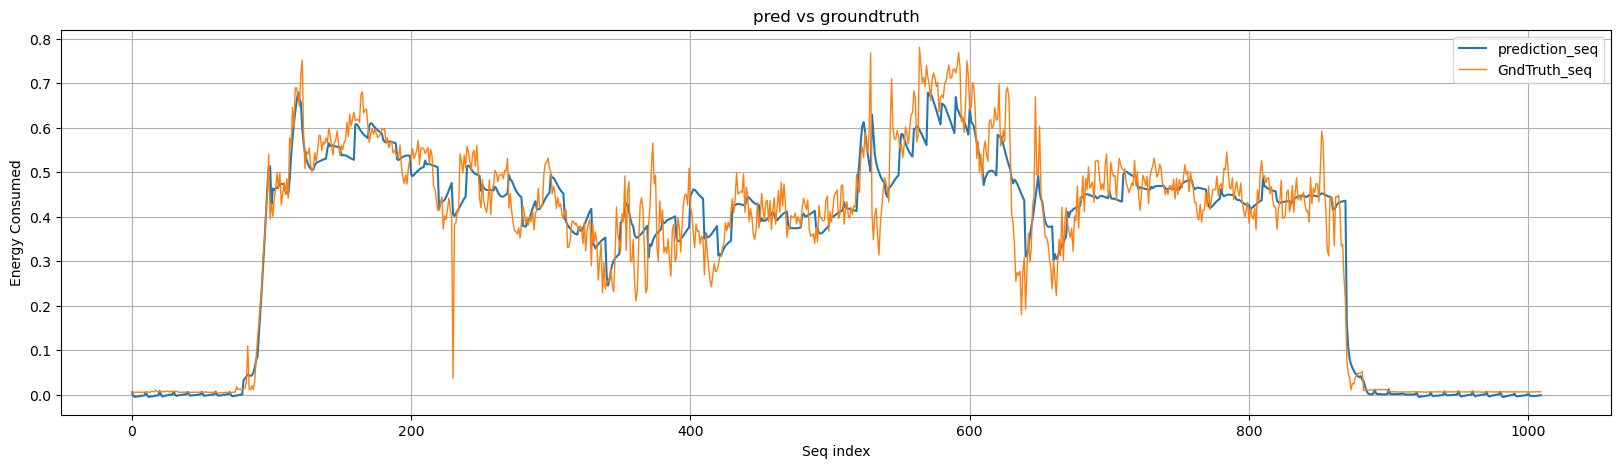

In [ ]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load('TCN_LSTM_select_best_model_24-10.pt'))

# Test the model
seq2seq.eval()
flight_num = 79 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,24,10)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [ ]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 31.388545224039824


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""